# Data Preprocessing

We'll focus on pre-processing as well as feature engineering, which is the art of creating meaningful features from your processed data. In general, you will likely have to use a combination of domain and statistical knowledge to get the most out of your variables. This includes techniques such as scaling and [transforming](https://machinelearningmastery.com/power-transforms-with-scikit-learn/) when dealing with time series data). It could also be the creation of new variables using some kind of combination of the variables that you have.

We will discuss basic feature transformations and feature selections. At best your model should  only include *relevant* variables. Any irrelevant variable will severely hamper the generalization properties of your model. 

We will discuss
- Data Preprocessing and Feature engineering
- Feature selection


In [ ]:
## package installation
# !pip install numpy
# !pip install pandas
# !pip install sklearn
# !pip install mlextend

## The HMEQ data set
Our data set, called the  "Home Equity" or, in brief, HMEQ data set, is provided by www.creditriskanalytics.net. It comprises  information about a set of borrowers, which are categorized along demographic variables and variables concerning their business relationship with the lender. A binary target variable called 'BAD' is  provided and indicates whether a borrower has repaid her/his debt. You can think of the data as a standard use case of binary classification.

You can obtain the data, together with other interesting finance data sets, directly from www.creditriskanalytics.net. The website also provides a brief description of the data set. Specifically, our data set consists of 5,960 observations and 13 features including the target variable. The variables are defined as follows:

- BAD: the target variable, 1=default; 0=non-default 
- LOAN: amount of the loan request
- MORTDUE: amount due on an existing mortgage
- VALUE: value of current property
- REASON: DebtCon=debt consolidation; HomeImp=home improvement
- JOB: occupational categories
- YOJ: years at present job
- DEROG: number of major derogatory reports
- DELINQ: number of delinquent credit lines
- CLAGE: age of oldest credit line in months
- NINQ: number of recent credit inquiries
- CLNO: number of credit lines
- DEBTINC: debt-to-income ratio

In German:
- BAD: die Zielvariable, 1=Standard; 0=nicht standardmäßig
- LOAN: Betrag der Darlehensanfrage
- MORTDUE: fälliger Betrag für eine bestehende Hypothek
- VALUE: Wert des aktuellen Besitzes
- REASON: DebtCon=Schuldenkonsolidierung; HomeImp = Heimwerkertätigkeit / Hausverbesserung
- JOB: Berufsgruppen
- YOJ: Jahre im gegenwärtigen Job
- DEROG: Anzahl der wichtigsten abfälligen Berichte
- DELINQ: Anzahl überfälliger Kreditlinien
- CLAGE: Alter der ältesten Kreditlinie in Monaten
- NINQ: Anzahl der letzten Kreditanfragen
- CLNO: Anzahl der Kreditlinien
- DEBTINC: Verhältnis von Schulden zu Einkommen


As you can see, the features aim at describing the financial situation of a borrower. We will keep using the data set for many modeling tasks in this tutorial and future tutorial. So it makes sense to familiarize yourself with the above features. Make sure you understand what type of information they provide and what this information might reveal about the risk of defaulting.  

## Pandas reloaded
The most common use case for the pandas lib is to load data that already exists on disk, a cloud drive, on the web, etc.

Loading such data into a `DataFrame` means that you load it into the main memory of your computer and can subsequently work with it. Note that loading larger data sets can take a long time and that they will consume a sizeable part of your main computer memory. More on that later. 

Remember that we have to load the Pandas library prior to using its classes. Let's do so and then examine a few options to load data. 

In [ ]:
import pandas as pd

# libraries for later use
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

### Loading data from disk
Say you have downloaded the data to your hard disk. It will be stored in some format in some folder somewhere on your computer. A common format for small data sets is the **csv** format, meaning comma separated values. This is also the format of our data. Before moving on, use a text editor to open the data and take a look at the format of the file. This is clarify what is meant by csv.

Pandas supports a variety of standard data formats including csv. To load the data, you will need to specify the full path to data file on your hard disk. The easiest way to do so is to put the data into your current working directory. Roughly speaking, this is the directory in which the Python interpreted is looking for files. You can identify the working directory as follows.

In [ ]:
# You have to update the code such that the variable file includes the correct path to the csv file on your computer
# file = './hmeq.csv'
df = pd.read_csv('https://www.dropbox.com/s/f5moewhma2jazjt/hmeq.csv?dl=1')

To convince yourself that data loading was successful, you can simply make Python outputting a summary of the data by typing the variable name of the data frame object; that is `df` in the example.

In [ ]:
df

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,88900,57264.0,90185.0,DebtCon,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347
5956,0,89000,54576.0,92937.0,DebtCon,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971
5957,0,89200,54045.0,92924.0,DebtCon,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590
5958,0,89800,50370.0,91861.0,DebtCon,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882


### Eyeballing data 
The Pandas data frame provides a ton of useful functions for data handling. We begin with showcasing some standard functions that one needs every time when working with data. This also allows us to re-visit some of the functions that we have seen in the Pandas part of the Python introduction. 

In [ ]:
# Query some properties of the data
print('Dimensionality of the data is {}'.format(df.shape))  # .shape returns a tuple
print('The data set has {} cases.'.format(df.shape[0]))     # we can also index the elements of that tuple
print('The total number of elements is {}.'.format(df.size))

Dimensionality of the data is (5960, 13)
The data set has 5960 cases.
The total number of elements is 77480.


In [ ]:
# Preview of the first n rows (similar to just typing the variable name as above but with more control)
df.head(n=10)
# Similarily, you can inspect the last rows
#df.tail(n=10)

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN
5,1,1700,30548.0,40320.0,HomeImp,Other,9.0,0.0,0.0,101.466002,1.0,8.0,37.113614
6,1,1800,48649.0,57037.0,HomeImp,Other,5.0,3.0,2.0,77.100000,1.0,17.0,NaN
7,1,1800,28502.0,43034.0,HomeImp,Other,11.0,0.0,0.0,88.766030,0.0,8.0,36.884894
8,1,2000,32700.0,46740.0,HomeImp,Other,3.0,0.0,2.0,216.933333,1.0,12.0,NaN
9,1,2000,NaN,62250.0,HomeImp,Sales,16.0,0.0,0.0,115.800000,0.0,13.0,NaN


In [ ]:
# Obtain a more technical overview of the data 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


In [ ]:
# Produce summary statistics (to R-programmers: this is equivalent to the famous R function summary())
df.describe()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


The previous demos gave as an overview of the data. However, if you compare the output to the describe() function list of features given on the www.creditriskanalytics.net website (see above), you will notice that we are missing some features. For example, we lack a summary of the feature REASON; same with JOB. If you think about it, that actually makes sense. The result from the function info() showed how these features are stored as data type object. They are not stored as numeric variables. In consequence, statistical / mathematical operations like computing a mean or quantile are undefined and cannot be computed for these variables. However, you can still force the describe() function to consider all features in its output.

In [ ]:
# The argument include all ensures that non-numeric variables are also shown
df.describe(include='all')

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5708,5681,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
unique,NaN,NaN,NaN,NaN,2,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,DebtCon,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,3928,2388,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.199497,18607.969799,73760.817200,101776.048741,NaN,NaN,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,NaN,NaN,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,NaN,NaN,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,NaN,NaN,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,NaN,NaN,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141


You can also calculate a summary statistic for each column individually by using the corresponding method, all methods can be found in the [Pandas reference](https://pandas.pydata.org/docs/reference/frame.html). In the below example, do not worry about the `sep` argument in the `print()` function. It just inserts two empty lines to make the output more readable.

In [ ]:
print(df.mean(), df.median(), sep="\n\n")  

BAD             0.199497
LOAN        18607.969799
MORTDUE     73760.817200
VALUE      101776.048741
YOJ             8.922268
DEROG           0.254570
DELINQ          0.449442
CLAGE         179.766275
NINQ            1.186055
CLNO           21.296096
DEBTINC        33.779915
dtype: float64

BAD            0.000000
LOAN       16300.000000
MORTDUE    65019.000000
VALUE      89235.500000
YOJ            7.000000
DEROG          0.000000
DELINQ         0.000000
CLAGE        173.466667
NINQ           1.000000
CLNO          20.000000
DEBTINC       34.818262
dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


### Navigating data
We discussed indexing numpy arrays and Pandas data frames in the first notebook tutorial. However, indexing is such a crucial part of working with data that it make sense to refresh our minds by including a few more demos. We will only illustrate some more popular options. A web search for "pandas data frame indexing" will provide many additional insights if you are interested. Likewise, feel free to skip this part if you already feel comfortable with data frame indexing.

#### Basic indexing of rows and columns

In [ ]:
# Accessing a single column by name
df['BAD']
# Alternatively
df.BAD

0       1
1       1
2       1
3       1
4       0
       ..
5955    0
5956    0
5957    0
5958    0
5959    0
Name: BAD, Length: 5960, dtype: int64

In [ ]:
# R-style indexing of selected rows and columns
df.loc[0:4, ["BAD", "LOAN"]]  

,BAD,LOAN
0,1,1100
1,1,1300
2,1,1500
3,1,1500
4,0,1700


In [ ]:
# Access columns by a numerical index
df.iloc[0:4, 0]
df.iloc[0:4, [0, 3, 5]]
df.iloc[0:4, np.arange(4)]

,BAD,LOAN,MORTDUE,VALUE
0,1,1100,25860.0,39025.0
1,1,1300,70053.0,68400.0
2,1,1500,13500.0,16700.0
3,1,1500,NaN,NaN


A few cautionary notes on numerical indexing in Python. The function `iloc()` considers the index of the data frame. In the above output, this is the left-most column without header. We have not defined a custom row index and Python uses consecutive integer numbers by default. However, a data frame could also have a custom index. In such a case, calls to `iloc()` need to refer to the custom index. It is good practice to eyeball a data frame and verify the way in which rows are indexed prior to using `iloc()`.
<br>

#### Other common forms of indexing and subset selection
It is also common practice to select rows based on comparisons of feature values.

In [ ]:
q = "NINQ>10"  # our query using the variable NINQ
tmp = df.query(q)
print('Number of applicants with {} is {}.'.format(q, tmp.shape[0]))
tmp

Number of applicants with NINQ>10 is 16.


,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
44,1,3000,NaN,14500.0,HomeImp,Other,3.0,0.0,0.0,9.300000,14.0,2.0,NaN
518,1,7200,54600.0,65000.0,DebtCon,Other,14.0,2.0,1.0,98.433333,11.0,9.0,NaN
1547,1,11300,56602.0,71500.0,DebtCon,Office,11.0,2.0,1.0,52.800000,12.0,20.0,NaN
1673,0,11900,71000.0,87000.0,DebtCon,Mgr,20.0,0.0,0.0,238.466667,11.0,24.0,NaN
2335,1,14100,43927.0,60000.0,DebtCon,Other,0.0,0.0,0.0,0.000000,12.0,8.0,NaN
2593,1,15000,NaN,26100.0,DebtCon,Other,1.6,0.0,1.0,105.466667,17.0,20.0,NaN
2599,1,15000,16400.0,205950.0,DebtCon,Mgr,10.0,8.0,3.0,135.933333,11.0,42.0,NaN
2748,0,15500,71412.0,93723.0,DebtCon,Mgr,19.0,0.0,0.0,238.501316,11.0,24.0,35.965898
2798,0,15700,79346.0,93472.0,DebtCon,Mgr,19.0,0.0,0.0,244.476057,11.0,23.0,33.196412
3661,1,19300,109000.0,135000.0,DebtCon,Office,3.0,0.0,0.0,98.433333,13.0,14.0,NaN


Alternatively, we can also use the function `loc()` for logical indexing. Here, we query all bad applicants and output the values of three features. 

In [ ]:
df.loc[df.BAD == 1, ['LOAN', 'JOB', 'YOJ']]

,LOAN,JOB,YOJ
0,1100,Other,10.5
1,1300,Other,7.0
2,1500,Other,4.0
3,1500,NaN,NaN
5,1700,Other,9.0
...,...,...,...
5930,72300,Other,1.0
5931,75400,Other,1.0
5932,76500,Other,12.0
5933,77200,Self,8.0


### Manipulating data
Data preparation (see next) will require us to change the data stored in a data frame. Let's introduce some functionality and concepts. 

#### The inplace Argument
When altering values in a data frame, you should know the argument `inplace`. Many function that result in changes support this argument. If set to `True`, whatever change was made to the data, it will be reflected right in the data frame. If set to `false`, on the other hand, the data frame to which the function was applied will not change. Instead, the function will only return a new data frame, which incorporates the change. Ok, that sounds rather theoretical. Let's look at an example. Consider the following call of the `sort_values` function. 

In [ ]:
df.sort_values(by="VALUE", ascending=False)

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
5752,1,43500,NaN,855909.0,HomeImp,Other,16.0,0.0,0.0,196.403636,0.0,23.0,42.985408
5707,1,41700,NaN,854114.0,HomeImp,Other,18.0,0.0,0.0,189.099378,1.0,23.0,43.258779
5706,1,41700,NaN,854112.0,HomeImp,Other,16.0,0.0,0.0,180.608878,0.0,23.0,42.071645
5665,1,40000,NaN,850000.0,HomeImp,Other,17.0,0.0,0.0,186.666667,1.0,24.0,NaN
5586,1,36600,397299.0,512650.0,DebtCon,ProfExe,4.0,0.0,0.0,197.516684,0.0,21.0,43.458327
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5817,1,50000,26976.0,NaN,DebtCon,Mgr,8.3,1.0,0.0,111.600000,1.0,6.0,NaN
5818,1,50000,106000.0,NaN,DebtCon,Mgr,0.8,0.0,2.0,252.633333,3.0,32.0,NaN
5822,1,50000,30338.0,NaN,DebtCon,Mgr,8.0,0.0,0.0,91.431005,0.0,5.0,35.084001
5826,1,50100,256431.0,NaN,NaN,Other,0.0,0.0,4.0,142.343205,2.0,25.0,3.342570


The purpose of `sort_values` is fairly obvious. Good to know this function exists. However, the point of the demo was to show that we obtain a changed data frame. Inspect the index (left-most column). We have changed the rows in the data frame by sorting, right. But have we really? Let's output the data frame one more time as we usefully do. 

In [ ]:
df

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,88900,57264.0,90185.0,DebtCon,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347
5956,0,89000,54576.0,92937.0,DebtCon,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971
5957,0,89200,54045.0,92924.0,DebtCon,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590
5958,0,89800,50370.0,91861.0,DebtCon,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882


Ok, this is the original row oder. Consequently, we **have not** changed the data frame by calling `sort_values`. Rather, the function has created a new data frame with the same content of the original one but altered row order. 

In [ ]:
df_changed = df.sort_values(by="VALUE", ascending=False) # we have to assign a variable to make this persistent

In [ ]:
df_changed

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
5752,1,43500,NaN,855909.0,HomeImp,Other,16.0,0.0,0.0,196.403636,0.0,23.0,42.985408
5707,1,41700,NaN,854114.0,HomeImp,Other,18.0,0.0,0.0,189.099378,1.0,23.0,43.258779
5706,1,41700,NaN,854112.0,HomeImp,Other,16.0,0.0,0.0,180.608878,0.0,23.0,42.071645
5665,1,40000,NaN,850000.0,HomeImp,Other,17.0,0.0,0.0,186.666667,1.0,24.0,NaN
5586,1,36600,397299.0,512650.0,DebtCon,ProfExe,4.0,0.0,0.0,197.516684,0.0,21.0,43.458327
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5817,1,50000,26976.0,NaN,DebtCon,Mgr,8.3,1.0,0.0,111.600000,1.0,6.0,NaN
5818,1,50000,106000.0,NaN,DebtCon,Mgr,0.8,0.0,2.0,252.633333,3.0,32.0,NaN
5822,1,50000,30338.0,NaN,DebtCon,Mgr,8.0,0.0,0.0,91.431005,0.0,5.0,35.084001
5826,1,50100,256431.0,NaN,NaN,Other,0.0,0.0,4.0,142.343205,2.0,25.0,3.342570


#### The apply function
More functionality that you need to know... It's getting a lot, right. Well, the good thing is that you can always come back to this notebook to look-up certain functions. That is the main reason why the notebook is so comprehensive, or long.
<br>
If you have used R, you will know the `apply()` function. It kinda does what the name suggests. It let's you define a function, either a custom one or one that already exist in Python, and apply that function to every element in a data frame. Combine that with indexing and you obtain a powerful way to selectively alter your data. 
<br>
We provide some demos in the following. To avoid corrupting our data frame, which we will need later, all demos use a copy. And for simplicity, we consider only the numerical features. 

In [ ]:
df_demo = df.select_dtypes(float) 

Say you want to square the values of all your features. Let's look at different forms of using `apply`. All three examples perform the same task, squaring all features in the data.

In [ ]:
# Using apply together with an existing function
df_demo.apply(np.square) # you can define a function directly like here, we have a square function

,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,6.687396e+08,1.522951e+09,110.25,0.0,0.0,8905.067778,1.0,81.0,NaN
1,4.907423e+09,4.678560e+09,49.00,0.0,4.0,14843.361110,0.0,196.0,NaN
2,1.822500e+08,2.788900e+08,16.00,0.0,0.0,22340.284445,1.0,100.0,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9.564840e+09,1.254400e+10,9.00,0.0,0.0,8711.111111,0.0,196.0,NaN
...,...,...,...,...,...,...,...,...,...
5955,3.279166e+09,8.133334e+09,256.00,0.0,0.0,49199.107177,0.0,256.0,1304.101571
5956,2.978540e+09,8.637286e+09,256.00,0.0,0.0,43552.380006,0.0,225.0,1285.937497
5957,2.920862e+09,8.634870e+09,225.00,0.0,0.0,45062.669618,0.0,225.0,1264.271127
5958,2.537137e+09,8.438443e+09,196.00,0.0,0.0,45750.090968,0.0,256.0,1179.296202


In [ ]:
# Using apply together with a customer function
def my_square(x):
    return x*x

df_demo.apply(my_square) 

,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,6.687396e+08,1.522951e+09,110.25,0.0,0.0,8905.067778,1.0,81.0,NaN
1,4.907423e+09,4.678560e+09,49.00,0.0,4.0,14843.361110,0.0,196.0,NaN
2,1.822500e+08,2.788900e+08,16.00,0.0,0.0,22340.284445,1.0,100.0,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9.564840e+09,1.254400e+10,9.00,0.0,0.0,8711.111111,0.0,196.0,NaN
...,...,...,...,...,...,...,...,...,...
5955,3.279166e+09,8.133334e+09,256.00,0.0,0.0,49199.107177,0.0,256.0,1304.101571
5956,2.978540e+09,8.637286e+09,256.00,0.0,0.0,43552.380006,0.0,225.0,1285.937497
5957,2.920862e+09,8.634870e+09,225.00,0.0,0.0,45062.669618,0.0,225.0,1264.271127
5958,2.537137e+09,8.438443e+09,196.00,0.0,0.0,45750.090968,0.0,256.0,1179.296202


In [ ]:
# Using apply together with a lamda function
df_demo.apply(lambda x: x * x) # you can define a function directly like here, we have a square function

,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,6.687396e+08,1.522951e+09,110.25,0.0,0.0,8905.067778,1.0,81.0,NaN
1,4.907423e+09,4.678560e+09,49.00,0.0,4.0,14843.361110,0.0,196.0,NaN
2,1.822500e+08,2.788900e+08,16.00,0.0,0.0,22340.284445,1.0,100.0,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9.564840e+09,1.254400e+10,9.00,0.0,0.0,8711.111111,0.0,196.0,NaN
...,...,...,...,...,...,...,...,...,...
5955,3.279166e+09,8.133334e+09,256.00,0.0,0.0,49199.107177,0.0,256.0,1304.101571
5956,2.978540e+09,8.637286e+09,256.00,0.0,0.0,43552.380006,0.0,225.0,1285.937497
5957,2.920862e+09,8.634870e+09,225.00,0.0,0.0,45062.669618,0.0,225.0,1264.271127
5958,2.537137e+09,8.438443e+09,196.00,0.0,0.0,45750.090968,0.0,256.0,1179.296202


## Data preparation steps / Data Preprocessing steps
Data preparation is a mega-topic. It will accompany us in one way or the other throughout the whole course. At this point, we will address some typical issues in our data and, in doing so, demonstrate how to perform standard data prep tasks using Python and Pandas. 

Here is an example of how your data preparation process could look like. This will of course depend on the data you are working with and the goal of your model. In general, you may **at least** want to follow these steps in no particular order:

- **Basic cleaning of null values, duplicates and outliers**

These values will have a big impact on how Python runs and how models are calculated. When it comes to NaN values and outliers, there are several approaches to deal with them. You could remove them, replace them with another value (indicator value, mode, mean, max, min, etc), use a mini-model to impute them among other options. This has been done for the most part in this data set already. 

- **Encode variables in the most appropriate way**

Check your dataframe using the method `.info()` . Are your continuous variables encoded as integers or floats? If they are type `object` then the column may need to be checked again for null values. It is good practice to change any categorical variables to the `category` data type as it increases processing time. Once you have confirmed that you will finalize the model with a categorical variable, it can be good to use one-hot encoding as described in step 5.

- **Ensure variables fit statistical assumptions/model requirements**

The next steps are a bit more complex and will depend on which model you need to use. Your goal is to make sure your data will be accurately processed by your model. Note that a lot of statistical assumptions depend on normal distribution and scaling. For example, models like K-Means and other distance-based methods are very sensitive to the magnitude of variable values.  We will first examine ways to do that.

In this step, you may also want to remove features which are highly correlated to one another.

- **Filter out variables with low predictive power**

You may now want to examine whether the variables contribute to your model. We will discuss filter methods to do just that. Note that some variables may only be effective in combination with others, so be careful with this step. Recall that wrapper methods for feature selection are more powerful but also more costly.  

- **One-hot encode categorical variables**

Once you have decided to keep a categorical feature, it can be useful to one-hot encode the feature. Again, one-hot encoding means that instead of one categorical column, you have multiple dummies, which represent possible category values. For example, if your categorical variable "transport" had the possible values of "car", "by foot" or "bus", you would split it into columns called "transport_car" and "transport_bus". "by foot" is indicated if neither of those have a value of 1 for that observation. In this tutorial, we will also learn about an alternative way to deal with categorical features using a weight-of-evidence (WoE) transformation.

- Double check the model only includes appropriate variables**

Next, you may want to try a step-wise regression feature selector as another check to ensure you are only including relevant variables.

In many cases, you may have to repeat some of these steps several times. Remember the idea of **garbage in, garbage out**. If you feed a model nonsense, expect nonsense to come right back out. This is likely what will take the most of your time as a data scientist.

## More Details on Preprocessing 

From Wikipedia on Data Pre-Processing:

"Data preprocessing can refer to manipulation or dropping of data before it is used in order to ensure or enhance performance,[1] and is an important step in the data mining process. The phrase "garbage in, garbage out" is particularly applicable to data mining and machine learning projects. Data-gathering methods are often loosely controlled, resulting in out-of-range values (e.g., Income: −100), impossible data combinations (e.g., Sex: Male, Pregnant: Yes), and missing values, etc.

Analyzing data that has not been carefully screened for such problems can produce misleading results. Thus, the representation and quality of data is first and foremost before running any analysis.[2] Often, data preprocessing is the most important phase of a machine learning project, especially in computational biology.[3] If there is much irrelevant and redundant information present or noisy and unreliable data, then knowledge discovery during the training phase is more difficult. Data preparation and filtering steps can take considerable amount of processing time. Examples of data preprocessing include cleaning, instance selection, normalization, one hot encoding, transformation, feature extraction and selection, etc. **The product of data preprocessing is the final training set.**"

**Let's begin!**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


The features *JOB* and *REASON* are stored as data type `object`. This is the most general data type in Python. A variable of this type can store pretty much any piece of data, numbers, text, dates, times, ... This generality has a price. The data type consumes a lot of memory. Further using a more specialized data type unlocks specific functionality, which is available only for that data type. Functions to manipulate text are an example. These are available for data of type `string`. 
<br>
In our case, the two features that Pandas stores as objects are actually categorical variables. We can easily verify this using `value_counts`, amongst others.

In [ ]:
df.REASON.value_counts()  # so REASON is a binary variable

DebtCon    3928
HomeImp    1780
Name: REASON, dtype: int64

In [ ]:
df.JOB.value_counts()  # whereas JOB is a multinomial variable 

Other      2388
ProfExe    1276
Office      948
Mgr         767
Self        193
Sales       109
Name: JOB, dtype: int64

Knowing our two "object features" are categories, we should alter their data type accordingly. To that end, we make use of the function astype, which facilitates converting one data type into another

In [ ]:
# Code categories properly 
df['REASON'] = df['REASON'].astype('category')
df['JOB'] = df['JOB'].astype('category')
df.info()  # verify the conversion was successful

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   BAD      5960 non-null   int64   
 1   LOAN     5960 non-null   int64   
 2   MORTDUE  5442 non-null   float64 
 3   VALUE    5848 non-null   float64 
 4   REASON   5708 non-null   category
 5   JOB      5681 non-null   category
 6   YOJ      5445 non-null   float64 
 7   DEROG    5252 non-null   float64 
 8   DELINQ   5380 non-null   float64 
 9   CLAGE    5652 non-null   float64 
 10  NINQ     5450 non-null   float64 
 11  CLNO     5738 non-null   float64 
 12  DEBTINC  4693 non-null   float64 
dtypes: category(2), float64(9), int64(2)
memory usage: 524.3 KB


Although it does not really matter for this tiny data set, note that the conversion from object to category has reduced the amount of memory that the data frame consumes. On my machine, we need 524.2 KB after the translation, whereas we needed more than 600 KB for the original data frame. If you work with millions of observations the above conversion will result in a significant reduction of memory consumption.
<br>
Let's change some more data types. The target variable is stored as an integer but we know that it has only two states. So we can convert the target to a boolean. Further, we might not need the numeric precision that the data type float64 provides. Downcasting to 32 bit precision should not affect modeling results too much. 
<br>If you feel uncomfortable with programming jargon (i.e., *downcasting*, number precision, ...) just accept the below part as another demo of Pandas functionality. Specifically, watch out for uses of the function `select_dtypes` in the below examples. A common use case when working with Pandas data frames is that you want to access all features (columns) of a certain data type and perform some operations with these columns; data type conversion being one example for the many operations you might want to perform.

In [ ]:
# The target variable has only two states so that we can store it as a boolean
df['BAD'] = df['BAD'].astype('bool')

# For simplicity, we also convert LOAN to a float so that all numeric variables are of type float
df['LOAN'] = df['LOAN'].astype(np.float64)

# Last, let's change all numeric variables from float64 to float32 to reduce memory consumption
num_vars = df.select_dtypes(include=np.float64).columns
df[num_vars] = df[num_vars].astype(np.float32)

Invest some time to understand the above codes. We are getting more and more advanced with Python. Our coding examples start to combine multiple pieces of functionality. For example, the above demo uses indexing, functions, function arguments to perform a task. Keep practicing and you will become familiar with the syntax. As always, if you do not understand certain bits, note down your questions so that we can discuss them in our discussion sessions.
<br>
Finally, let's verify our changes once more.

In [ ]:
df.info() # Check memory consumption after the converstions

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   BAD      5960 non-null   bool    
 1   LOAN     5960 non-null   float32 
 2   MORTDUE  5442 non-null   float32 
 3   VALUE    5848 non-null   float32 
 4   REASON   5708 non-null   category
 5   JOB      5681 non-null   category
 6   YOJ      5445 non-null   float32 
 7   DEROG    5252 non-null   float32 
 8   DELINQ   5380 non-null   float32 
 9   CLAGE    5652 non-null   float32 
 10  NINQ     5450 non-null   float32 
 11  CLNO     5738 non-null   float32 
 12  DEBTINC  4693 non-null   float32 
dtypes: bool(1), category(2), float32(10)
memory usage: 250.7 KB


### Missing values
You might have already noticed that our data contains many missing values. This is common when working with real data. Likewise, handling missing values is a standard task in data preparation. Let's learn how Pandas supports handling missing values.  The function `.isnull()` is the entry point to the corresponding functionality and helps with identifying the relevant cases.

In [ ]:
# Boolean mask to access missing values
df.isnull()
# Note that the above is equivalent to
df.isna()
# Both versions are available in Python to sustain backward compatibility. We suggest you select one and stick to it 

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,False,False,False,False,False,False,False,False,False,False,False,False,True
1,False,False,False,False,False,False,False,False,False,False,False,False,True
2,False,False,False,False,False,False,False,False,False,False,False,False,True
3,False,False,True,True,True,True,True,True,True,True,True,True,True
4,False,False,False,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,False,False,False,False,False,False,False,False,False,False,False,False,False
5956,False,False,False,False,False,False,False,False,False,False,False,False,False
5957,False,False,False,False,False,False,False,False,False,False,False,False,False
5958,False,False,False,False,False,False,False,False,False,False,False,False,False


We can easily count the total number of missing values as shown below. Pause here and make sure you fully understand why we call the `sum()` function twice. I strongly recommend debugging the code. For example, inspect the output after removing the second call to `sum()`.

In [ ]:
# count the total number of missing values
df.isnull().sum().sum()

5271

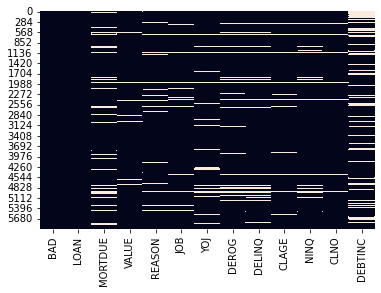

In [ ]:
sns.heatmap(df.isnull(), cbar=False);  # quick visualization of the missing values in our data set

### Categorical features
Let's start with the two categorical features. The heatmap suggests that `REASON` exhibits more missing values than `JOB`. We will treat them differently for the sake of illustration. Now that we start altering our data frame more seriously, it is a good idea to make a copy of the data so that we can easily go back to a previous state.

In [ ]:
df_orig = df.copy() # copy data

One way to treat missing values in a categorical feature is to simply introduce a new category level. We will demonstrate this approach for the feature *REASON*. One feature of the category data type in Pandas is that category levels are managed. In a nutshell, we cannot change data or enter new data arbitrarily. Before assigning the missing values our new category level *IsMissing*, we first need to introduce this level. We basically tell our data frame that *IsMissing* is another suitable entry for *REASON* next to the levels that already exist in the data frame. 

In [ ]:
# Variable REASON: we treat missing values as a new category level.
# First we need to add a new level
df.REASON.cat.add_categories(['IsMissing'], inplace=True)
# Now we can do the replacement
df.REASON[df.REASON.isnull() ] = "IsMissing"
df.REASON.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


0      HomeImp
1      HomeImp
2      HomeImp
3    IsMissing
4      HomeImp
Name: REASON, dtype: category
Categories (3, object): ['DebtCon', 'HomeImp', 'IsMissing']

In [ ]:
df.REASON.isna().sum()  # verify that no more missing values exist

0

Ok, that worked. On to the next category. 
<br>
For the feature *JOB*, which is multinomial, we will use a different approach for illustration. We replace missing values with the mode (most frequent category level; just in case). That is actually a crude way to handle missing values but its used quite a lot. I'm not endorsing it! But you should have at least seen a demo. Here it is. 

In [ ]:
df.JOB.mode() # Determine the mode
df.JOB.value_counts() # alternative

Other      2388
ProfExe    1276
Office      948
Mgr         767
Self        193
Sales       109
Name: JOB, dtype: int64

In [ ]:
# replace missing values with the mode
df.JOB[df.JOB.isnull() ] = df.JOB.mode()[0]  # the index [0] ensures that we only extract the value from the result of calling mode()
df.JOB.head()

0     Other
1     Other
2     Other
3     Other
4    Office
Name: JOB, dtype: category
Categories (6, object): ['Mgr', 'Office', 'Other', 'ProfExe', 'Sales', 'Self']

### Numerical features
We have a lot of numerical features. To keep things simple, we simply replace all missing values with the median. Again, this is  a crude approach that should be applied with utmost care if at all. However,  it nicely shows how we can process several columns at once using a loop. 

In [ ]:
for col in df.select_dtypes(include='float32').columns:  # loop over all numeric columns
    if df[col].isna().sum() > 0:                         # check if there are any missing values in the current feature
        m = df[col].median(skipna=True)                  # compute the median of that feature
        df[col].fillna(m, inplace=True)                  # replace missing values with the median

In [ ]:
# see if it worked, count again
df.isnull().sum().sum()

0



## First glimpse at Train / Dev / Test splits of the data:  The holdout method

The train validation/dev test split is a technique for partitioning data into training, validation/development, and test sets.

A statistical model is initially fit on a training data set, which is a set of examples used to fit the parameters (e.g. weights of connections between neurons in artificial neural networks) of the model. The model is trained on the training data set, for example using optimization methods such as gradient descent or stochastic gradient descent. 

Successively, the fitted model is used to predict the responses for the observations in a second data set called the validation data set or development data set. The validation data set provides an unbiased evaluation of a model fit on the training data set while tuning the model's hyperparameters (e.g. the number of hidden units—layers and layer widths—in a neural network). 

Finally, the test data set is a data set used to provide an unbiased evaluation of a final model fit on the training data set with hyperparameters tuned on the validation/development set. 

In case we sample only once and obtain one each of train, dev and test data sets, this is called the holdout method. This is totally fine for most applications, in specific, when model training is costly. More advanced schemes exist, the most prominent being the cross-validation approach. More on that later...

In [ ]:
# Import standard Python libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Some configuration of the plots we will create later
%matplotlib inline  
plt.rcParams["figure.figsize"] = (12,6)

# Load credit risk data in pre-processed format (just to have it processed already just in case)
#data_url = './hmeq_prepared.csv' 
#df = pd.read_csv(data_url)

# we need a train test split for the following steps
# Extract target variable and feature matrix 
X = df.drop(['BAD'], axis=1) 
y = df[['BAD']]

# respect train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

X_train.head()

,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
4223,22000.0,48000.0,80990.0,DebtCon,Mgr,6.0,0.0,0.0,262.733337,2.0,26.0,34.818260
3081,16700.0,53423.0,85685.0,HomeImp,ProfExe,5.0,0.0,0.0,109.429428,0.0,12.0,28.160612
1647,11800.0,52104.0,61618.0,DebtCon,Office,0.0,0.0,0.0,160.749939,0.0,21.0,37.129513
2816,15800.0,9407.0,60165.0,DebtCon,Sales,1.0,0.0,0.0,310.658417,0.0,5.0,40.051308
5374,30800.0,195221.0,293118.0,DebtCon,Other,29.0,0.0,0.0,151.957413,0.0,22.0,38.181026


In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4768, 12) (1192, 12) (4768, 1) (1192, 1)


In [ ]:
# Let's get a quick overview of the data types of each column again and make sure they are correct
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4768 entries, 4223 to 3551
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   LOAN     4768 non-null   float32 
 1   MORTDUE  4768 non-null   float32 
 2   VALUE    4768 non-null   float32 
 3   REASON   4768 non-null   category
 4   JOB      4768 non-null   category
 5   YOJ      4768 non-null   float32 
 6   DEROG    4768 non-null   float32 
 7   DELINQ   4768 non-null   float32 
 8   CLAGE    4768 non-null   float32 
 9   NINQ     4768 non-null   float32 
 10  CLNO     4768 non-null   float32 
 11  DEBTINC  4768 non-null   float32 
dtypes: category(2), float32(10)
memory usage: 233.2 KB


Luckily, most of our variables are actually encoded the right way! Let's just change the two categorical variables to a categorical type. Note that this is not a data type in `NumPy`, only in `Pandas`. As such, you may run into problems if the data type becomes relevant in a `NumPy` calculation. Just keep that in mind!

## Explanatory data analysis (EDA) and EDA-inspired Preprocessing




Now that we are familiar with Pandas and have prepared out data, at least rudimentary, we can explore some of the plotting capabilities in Python. To that end, we go through an EDA pipeline and try to improve our understanding of the data along the way.
<br>
### Univariate analysis of categorical variables
In this part, we will examine  our target variable 'BAD', as well as the two categorical variables 'REASON' and 'JOB' individually. Firstly, we will count how many observations belong to each category of a variable. The function `value_counts()`, which we already saw above is probably the best choice to do that. We can also use it to process all categories in one go, as follows:

In [ ]:
df.select_dtypes(exclude='float32').apply(pd.Series.value_counts).fillna(0, downcast='infer')

,BAD,REASON,JOB
False,4771,0,0
True,1189,0,0
DebtCon,0,3928,0
HomeImp,0,1780,0
IsMissing,0,252,0
Mgr,0,0,767
Office,0,0,948
Other,0,0,2667
ProfExe,0,0,1276
Sales,0,0,109


In [ ]:
df.dtypes

BAD            bool
LOAN        float32
MORTDUE     float32
VALUE       float32
REASON     category
JOB        category
YOJ         float32
DEROG       float32
DELINQ      float32
CLAGE       float32
NINQ        float32
CLNO        float32
DEBTINC     float32
dtype: object

<br>
While tables are a useful way to inspect data, graphs are often easier to interpret and more appealing. For categories, count plots and stacked count plots are common vehicles for data exploration. 

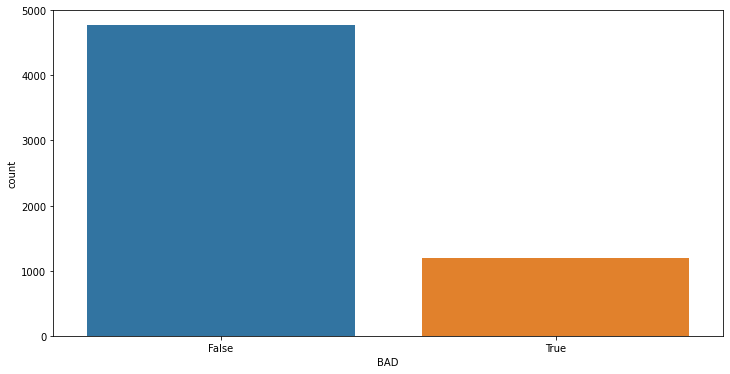

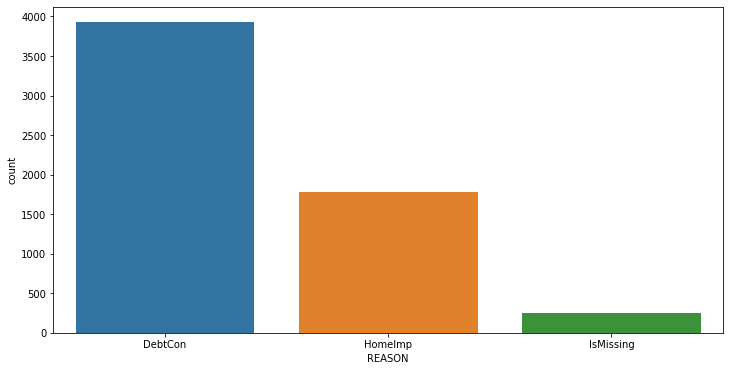

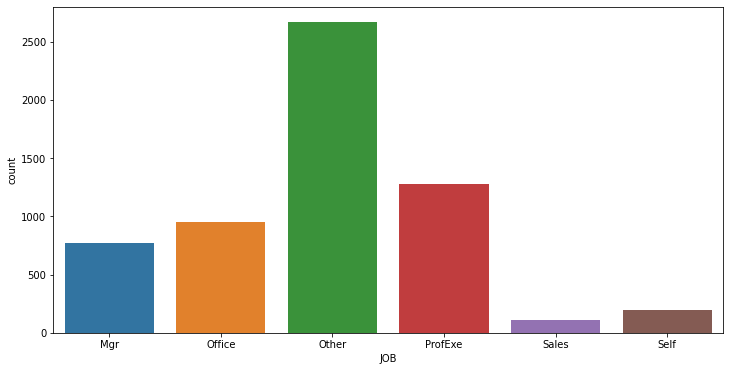

In [ ]:
# exluding data type float leaves us with the target variable and both categorical variables
for i, col in enumerate(df.select_dtypes(exclude=['float64','float32']).columns):
    plt.figure(i)
    sns.countplot(x=col, data=df)

### Univariate analysis of numeric variables
Let us now take a closer look at the numeric variables and their distribution by means of histograms. Creating a histogram is easily achieved using the `hist()` function, which Pandas offers. We will use it below.
Dedicated plotting libraries offer a bit more flexibility. For start, we showcase functionality of the `Seaborn` library. We recommend this version when you examine a single variable at a time.

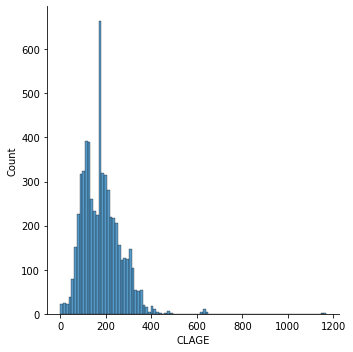

In [ ]:
# Demo of a histogram using Seaborn
sns.displot(df['CLAGE']);  # Explore the arguments that the function supports to discober variants of the plot

Next, we consider a basic histogram and use Pandas functionality to produce an overview of all the numeric variables in the data.

<Figure size 864x576 with 0 Axes>

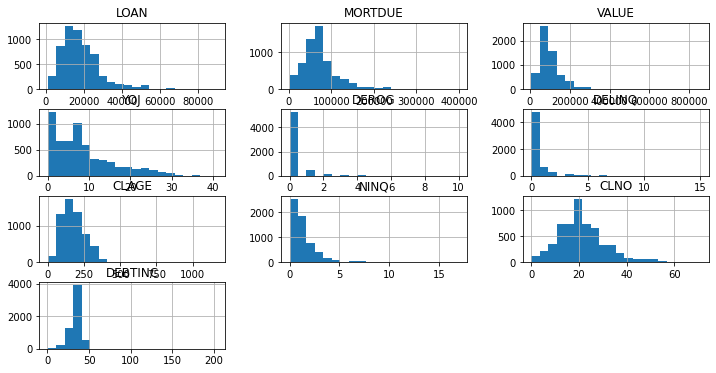

In [ ]:
plt.figure(figsize=(12,8))  # enlarge the figure
# We create one histogram for each numeric variable and illustrate how to set the number of bins
df.select_dtypes(include=['float32','float64']).hist(bins=20); 

We observe many variables to have a long tail. This is very common in real data. Outliers also seem to be an issue in this data set. To get a clearer view on outliers let's inspect boxplots.

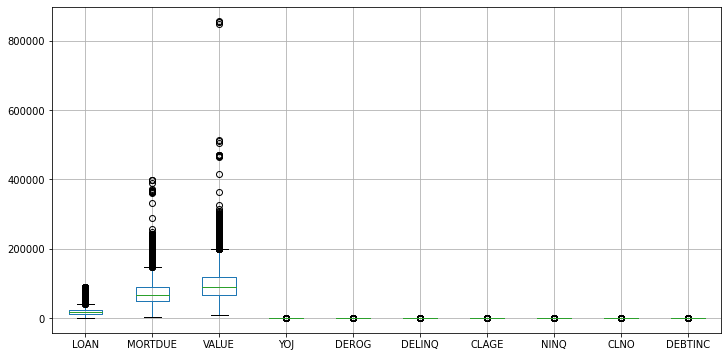

In [ ]:
# Nice way to do it quickly
num_vars = df.select_dtypes(include=['float32','float64'])
df.boxplot(column=list(num_vars));

While the little amount of code in the above example is clearly nice, it is immediately clear that the above plot suffers from the fact that the numerical variables have different scale. Standardization could be a way to remedy this issue and we will look at it later. For now, we can extend our code to create one boxplot for each variable. 

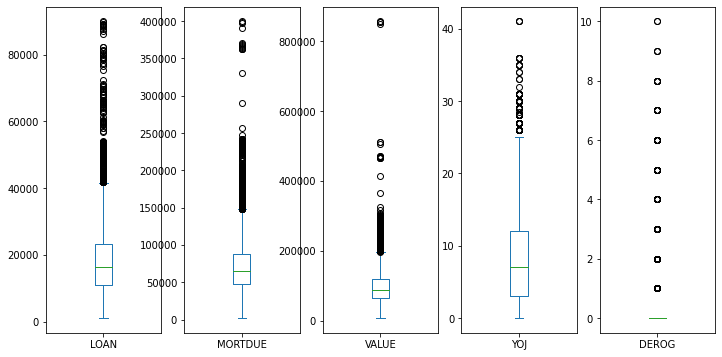

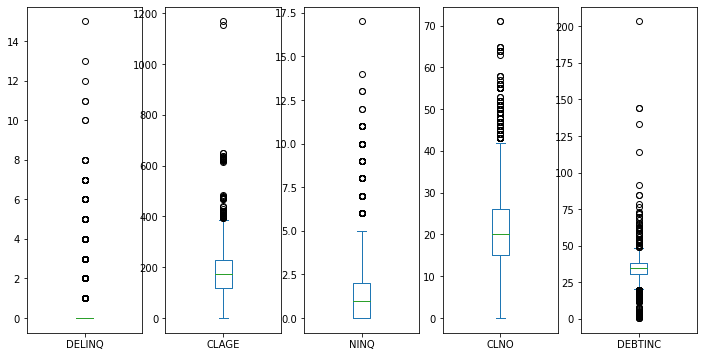

In [ ]:
# One boxplot for each variable
num_vars = df.select_dtypes(include=['float32','float64'])
half = np.ceil(num_vars.shape[1] / 2).astype(int)  # for cosmetic reasons we split the plots into two rows
num_vars.iloc[:, 0:half].plot(kind = 'box', subplots=True);
num_vars.iloc[:, half:num_vars.shape[1]].plot(kind = 'box', subplots=True);

### Outlier handling
Ok, so outliers are indeed a problem. We will truncate them based on Tukey's rule of thumb. At this point, we can finally come back to the `.apply()` function and provide a more meaningful example of how to use it. Specifically, we implement a function that takes care of outlier truncation. We then `.apply()` this function to our data. In comparison to a loop, which facilitates the same type of operation, `.apply()` may be more and leads to more readable code. It is fair to say that `apply()` is often preferred over loops.

In [ ]:
# we first need our function to handle outliers 
def outlier_truncation(x, factor=1.5):
    '''
    Identifies outlier values based on the inter-quartile range IQR. 
    Corresponding outliers are truncated and set to a contant value equal to the IQR
    times a factor, which, following Tuckey's rule, we set to 1.5 by default
    
        Parameters:
            x (Pandas Series): A data frame column to scan for outliers
            factor (float): An outlier is a value this many times the IQR above q3/below q1
            
        Returns:
            Adjusted variable in which outliers are truncated
    '''
    x_new = x.copy()
    
    # Calculate IQR
    IQR = x.quantile(0.75) - x.quantile(0.25) 
    
    # Define upper/lower bound
    upper = x.quantile(0.75) + factor*IQR
    lower = x.quantile(0.25) - factor*IQR
    
    # Truncation
    x_new[x < lower] = lower
    x_new[x > upper] = upper
    
    return x_new

We could simply apply the above function to every numeric variable. This would work. However, if you go back to the boxplots, and look carefully, you may notice that some variables need special treatment. Consider the variable `DEROG`. If you simply truncate outliers in this variable, the result will be a constant. Make sure you understand why this is the case. We will leave such special cases for later and process the other less troublesome variables using our outlier truncation function.

In [ ]:
# Select numeric variables for outlier treatment. We could also use select_dtypes(). Do so if you prefer.
# The programming construct we use is called list comprehension and quite common in Python. Think of it
# as a more efficient way of writing loops
num_cols = [x for x in df.columns if df[x].dtype == 'float32' and x not in ['DEROG', 'DELINQ']]  

# Process every selected column using apply
# Updated 10.06.20 to show passing arguments to the 'applied' functions. Just send a tupel with arguments in the order as specified
# by the called function leaving out the first argument (see, https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.apply.html)
df[num_cols] = df[num_cols].apply(outlier_truncation, axis=0, args=(3,))  
df.describe()

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000
mean,18459.177734,72326.507812,100527.976562,8.755159,0.224329,0.405705,179.014542,1.148322,21.235907,33.919411
std,10500.744141,39437.328125,50639.355469,7.255089,0.798458,1.079256,80.768532,1.538720,9.901447,6.568136
min,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.202968
25%,11100.000000,48139.000000,66489.500000,3.000000,0.000000,0.000000,117.371429,0.000000,15.000000,30.763160
50%,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466660,1.000000,20.000000,34.818260
75%,23300.000000,88200.250000,119004.750000,12.000000,0.000000,0.000000,227.143051,2.000000,26.000000,37.949891
max,59900.000000,208384.000000,276550.500000,39.000000,10.000000,15.000000,556.457886,8.000000,59.000000,59.510082


Note how the maximum values have changed. You can also re-run the above code to create the boxplots and convince yourself that we have mitigated the outlier problem. 

## Scaling

Features will likely have arbitrary magnitudes. For example, a customer's spending range from 0 to 50,000 but a dummy variable about them may only take the value 0 or 1. For many algorithms, like the distance function in kMeans, this is problematic. The distance function will try to minimize differences among features using their raw values. This means that kMeans will focus on variables with arbitrarily high values like spending when that may not be as important as a dummy. One way to deal with this is to scale features so that their values are in a controlled range; without altering the distribution of feature values. This way, all features will be considered equally in distance calculations. 

There are two major ways to scale: standardization and min-max scaling (also known as normalization).

### Standardization
After standardization, your feature will now be distributed around a mean  feature value of zero with standard deviation equal to one.

$$ X_{new} = \frac{X-\mu}{\sigma} $$

There is no controlled or a priori set maximum or minimum value here. This means that standardization does not deal with outliers. You may have a clearer picture of how extreme these outliers are after standardization.

### Min-Max Scaling
After min-max scaling, your variables will have a range of 0 and 1. Minimum feature values will become 0 and maximum values will be 1.

$$ X_{new} = \frac{X-X_{min}}{X_{max}-X_{min}} $$

**NOTE** This type of scaling is sometimes called normalization but you should note that it simply compacts the values of the features to be between 0 and 1, it does not change the overall shape of the data.


In [ ]:
# Standardization
def standardize(var):
    return (var - np.mean(var)) / np.std(var)


# Min-max scaling
def min_max_scale(var):
    return (var - min(var)) / (max(var) - min(var))

Let's first look at how this variable looks before and after normalization and standardization using a box plot and then a histogram. **Note the scaling of the y-axes in all of all the following plots.**

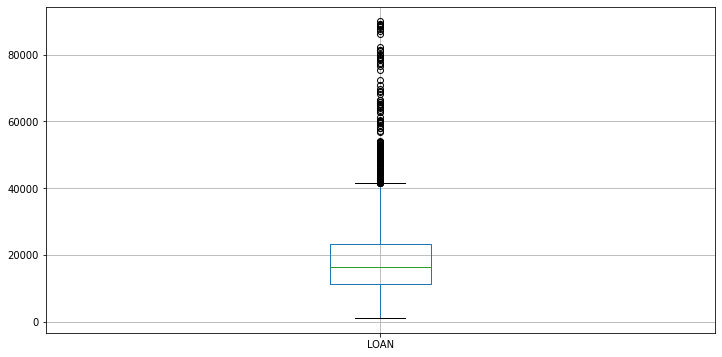

In [ ]:
# Raw variable 
X_train[['LOAN']].boxplot();

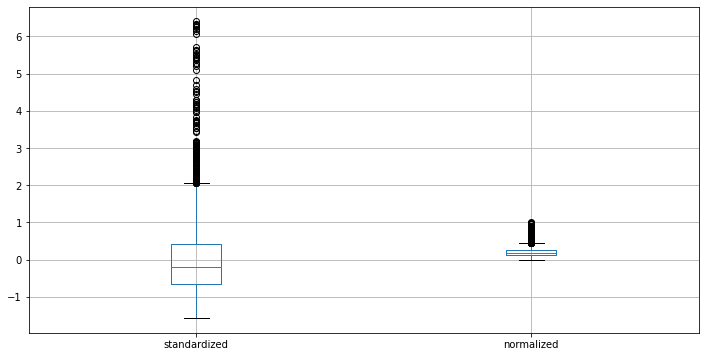

In [ ]:
# Comparison of the normalized vs. standardized variable (check axes for size)
loan_standardized = standardize(X_train['LOAN'])
loan_normalized = min_max_scale(X_train['LOAN'])
loans_scaled = pd.DataFrame({"standardized": loan_standardized, "normalized": loan_normalized})
loans_scaled.boxplot();

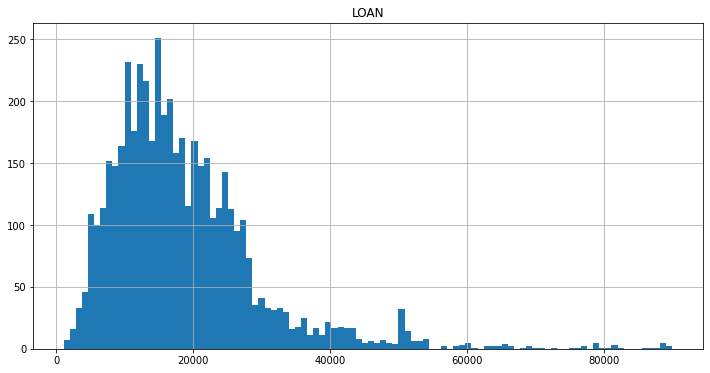

In [ ]:
# Histogram of raw variable
X_train[['LOAN']].hist(bins=100);

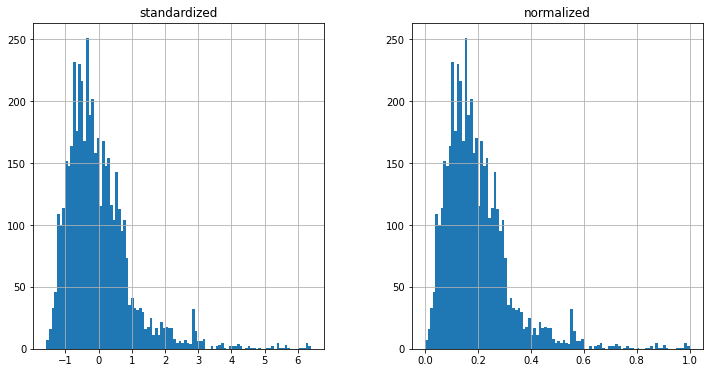

In [ ]:
# Comparison of the normalized vs. standardized variable (check axes for size)
loans_scaled.hist(bins=100);

Now we can see the big difference between the two types of scaling. With min-max scaling, we have the variable ranging between 0 and 1. With standard scaling, we have the variable showing us its position relative to standard deviations. Note that in both of these examples, the variable was squeezed into a smaller range but did not change shape overall. There are ways to change its shape, which we will explore next. 

First, let's just quickly look at the standard way to perform scaling when using `sklearn`. We can just use the `MinMaxScaler()` and `StandardScaler` to do what our custom functions did. In practice, we would rely on these routines and avoid coding our own customer functions.

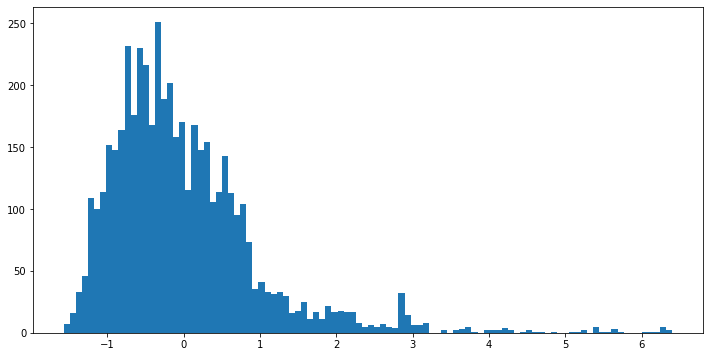

In [ ]:
from sklearn.preprocessing import StandardScaler
standardscaler = StandardScaler()
standardscaled = standardscaler.fit_transform(X_train[['LOAN']])
_ = plt.hist(standardscaled, bins=100)
plt.show()

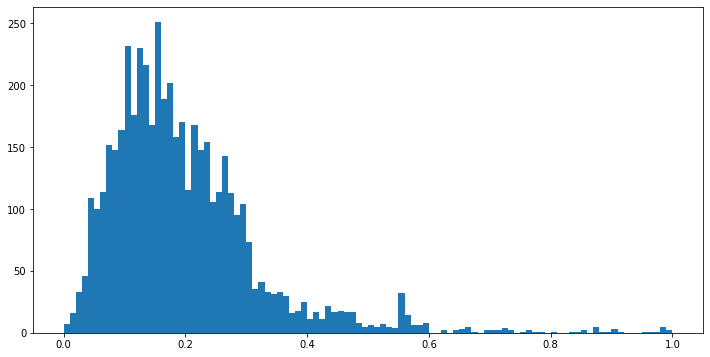

In [ ]:
from sklearn.preprocessing import MinMaxScaler
minmaxscaler = MinMaxScaler()
minmaxscaled = minmaxscaler.fit_transform(X_train[['LOAN']])

_ = plt.hist(minmaxscaled, bins=100)
plt.show()

It is good practice to scale variables before putting them into an algorithm. Note that some algorithms (eg. tree algorithms) don't necessarily require this. Since we will be using a logistic regression initially, we will scale these variables using standard scaling later.

## Checking features for normality

Normality is a critical condition for many statistical tests and the creation of confidence intervals. If this is the goal of your work, you will likely need to find some way to normalize your variables. Further, some methods for descriptive, explanatory or predictive modeling may benefit from normality. Imagine, for example, a dependent variable that displays a complex, non-normal distribution. If the distribution of the dependent is non-normal, it is likely that residuals will also be non-normal, which vialoates an assumption of the linear model. Long story short, many importand data science methods may benefit from feature transformations that change the distribution of a feature such that it becomes more normal. Here we will introduce 3 useful transformations to achieve this: log, Box-Cox and Yeo-Johnson transformations.

There are several ways to check which variables could benefit from such a transformation. One method would be to create a histogram of each variable and check its shape. Remember that you are looking for a perfect bell shape with even tails on either side. As you can imagine, this does not happen very often with many variables.

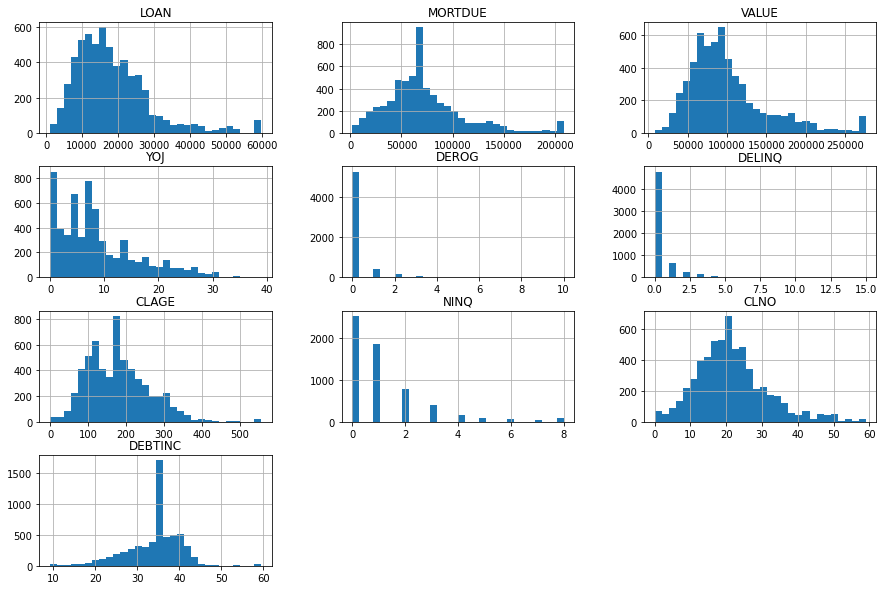

In [ ]:
df.select_dtypes(include=['float64','float32']).hist(bins=30, figsize=(15, 10));

In [ ]:
# Choose a feature of interest and we'll take a deep dive into it
# DEROG, DELINQ and NINQ are bad candidates as they resemble categorical variables
feature = df['LOAN'] 

If you would like a more scienfitic test for normality, you can use `normaltest` from `scipy`. This function's documentation is [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html). It outputs 2 numbers, the first is the sum of squares of the z-scores returned by a skewtest and kurtosistest. The second is a 2-sided chi2 probability hypothesis test. Thus, if the p-value is below 0.05, it is likely you do not have normally distributed data.

In [ ]:
from scipy import stats
stats.normaltest(feature)

NormaltestResult(statistic=1603.653442252271, pvalue=0.0)

We can see problems a bit more clearly with a quantile-quantile (QQ) plot. Ideally, the blue line should match the red line (quantiles of a feature versus the quantiles/ppf of a distribution). If not, it is less likely that it comes from a normal distribution.

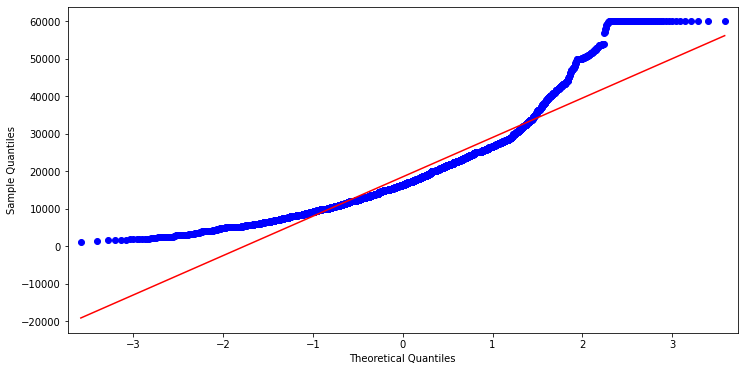

In [ ]:
from statsmodels.graphics.gofplots import qqplot
qqplot(feature, line='s')
plt.show()

Just to reiterate that it is a bit misleading to say min-max scaling is "normalization", let's min-max scale our feature and perform the test. As we can see, `normaltest` outputs the same test statistic and pvalue.

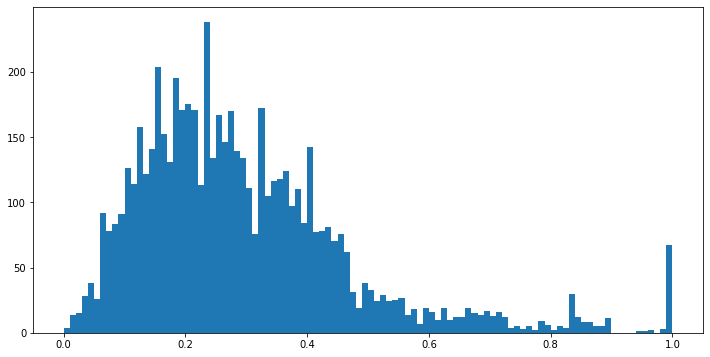

In [ ]:
minmaxscaled_feature = minmaxscaler.fit_transform(pd.DataFrame(feature))
_ = plt.hist(minmaxscaled_feature, bins=100)
plt.show()

In [ ]:
stats.normaltest(minmaxscaled_feature)

NormaltestResult(statistic=array([1603.6528], dtype=float32), pvalue=array([0.]))

If you need your variable to have a normal distribution, it's going to take more than min-max scaling!

## Common feature transformations for numeric data

Wikipedia on "power transforms":

In statistics, a power transform is a family of functions applied to create a monotonic transformation of data using power functions. It is a data transformation technique used to stabilize variance, make the data more normal distribution-like, improve the validity of measures of association (such as the Pearson correlation between variables), and for other data stabilization procedures.



### Log Transformation
One major use of logs is to create linearity from exponential relationships. This can help algorithms (e.g., linear models) capture the fit of many variables. Remember that logs take only strictly positive variables. If you have any negative values, you will have to rescale your data, remove them or find another way to deal with them.

$ x^{(t)} = g(x) = log(x) $



### Box Cox Transformation
If your variable has a skewed tail, this can be problematic for the assumption on normality. You can try to correct this with a Box Cox transformation. This only works with strictly positive values (greater than 0). You can always rescale variables so they meet this criteria before putting them into this formula.

$
    x^{(t)} = g(x; \lambda) =
    \begin{cases}
      \frac{x^\lambda - 1}{\lambda}, & \text{if}\ \lambda \neq 0 \\
      log(x), & \text{otherwise}
    \end{cases}
$




## Testing transformations
Let's look at a version of these which we have created from scratch and check what they do to our variable using histograms and box plots.

In [ ]:
def box_cox_transform(var, power=0):

    try:
        assert (var > 0).all()  # Function only defined > 0
    except AssertionError:
        raise ValueError("Variable values must be strictly positive")

    # Special case lambda=0
    if power == 0:
        var = np.log(var)

    else:
        var = (var ** power - 1) / power

    return var

Now let's check the histogram of the regular feature of interest and its modified versions. Pay attention to the scale. What happens as the power of the BC and YJ transformation increases? What happens to the shape of the histogram?

In [ ]:
# Adjust coefficient of Box Cox transformation on the feature to show plot below

bc1 = box_cox_transform(feature+1, power=0)  # Adding 1 as all features start at 0, not allowed in BC
bc2 = box_cox_transform(feature+1, power=.5)
bc3 = box_cox_transform(feature+1, power=1)

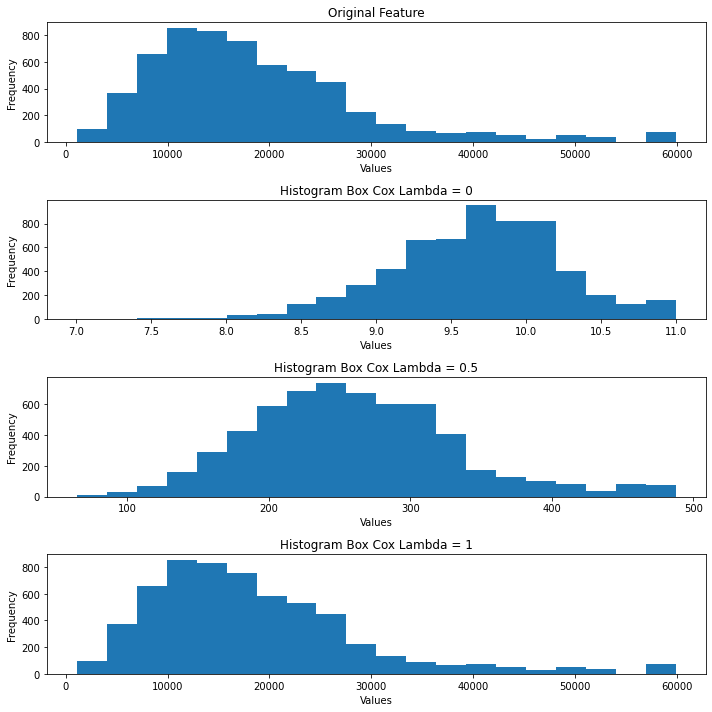

In [ ]:
# Plot a histogram per coefficient of BC transformation

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1)
fig.set_figheight(10)
fig.set_figwidth(10)

ax1.hist(feature, bins=20)
ax2.hist(bc1, bins=20)
ax3.hist(bc2, bins=20)
ax4.hist(bc3, bins=20)

ax1.set_title('Original Feature')
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Values')

ax2.set_title('Histogram Box Cox Lambda = 0')
ax2.set_ylabel('Frequency')
ax2.set_xlabel('Values')


ax3.set_title('Histogram Box Cox Lambda = 0.5')
ax3.set_ylabel('Frequency')
ax3.set_xlabel('Values')


ax4.set_title('Histogram Box Cox Lambda = 1')
ax4.set_xlabel('Values')
ax4.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Did you notice that the peak of the data moves? We are looking for a sweet spot where the peak is somewhere directly between the two tails so the distribution is almost perfectly bell-shaped. Note that the scale also changes pretty dramatically too. Make sure that you scale this variable after if necessary to make sure it fits your model requirements!

### Using `scipy` functions
Let's use the scipy version of the function and  see where it finds the true maximum point of normality. We can use the `scipy`  `stats` sublibrary to fit the feature and find the optimal lambda. Let's first start with Box Cox.

In [ ]:
bc_fitted_feature, bc_fitted_lambda = stats.boxcox(feature+1) # Again, we are adding 1 because all features have 0s (not allowed in BC)

bc_fitted_lambda

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:912: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


0.1912898934643943

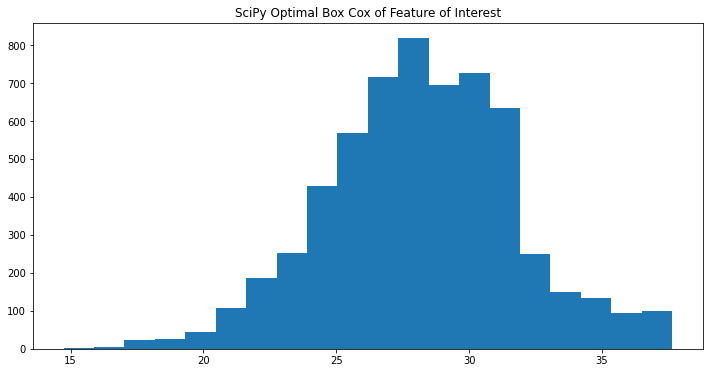

In [ ]:
plt.hist(bc_fitted_feature, bins=20)
plt.title('SciPy Optimal Box Cox of Feature of Interest')
plt.show()

Lastly, let's do the normal test one last time with the optimal lambda found by `scipy`. We can see that the test statistic does not exceed the desired 0.05 but is much better than what we were dealing with previously.

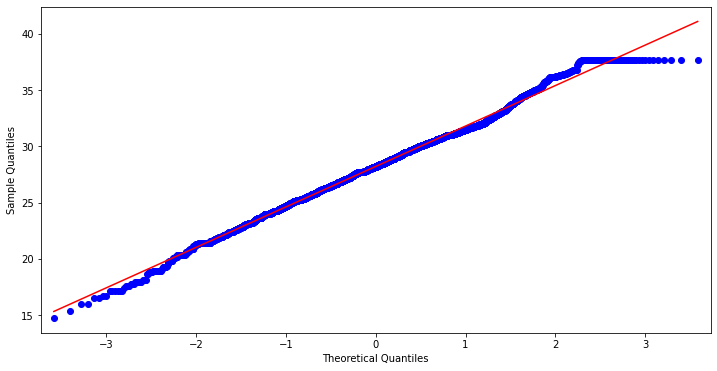

In [ ]:
qqplot(bc_fitted_feature, line='s')
plt.show()



## Beware of in-sample biases when transforming features! This means: Respect the train/test splitting!

So, before we continue let's quickly just apply a simple transform to all of our variables. We will just standardize them for now. Remember that you should be doing any transformations separately to your train data and test data. You want to try to keep your test data as pure as possible. If you make transformations before, you risk not having a truly representative sample of new unseen data to test your model on. To see this, recall that scaling involves computing statistics like the mean, standard deviatio or min/max. It makes a difference whether you compute these statistics only from the training data or from the combination of the training and test date. Thus, first scaline the data and then splitting it into training and test is a bad idea. The scaler classes in `sklearn` are designed in a way to help you avoid this flaw. 

In [ ]:
numeric_cols = ["LOAN", "MORTDUE", "VALUE", "YOJ", "DEROG", "DELINQ", "CLAGE", "NINQ", "CLNO", "DEBTINC"]

standard = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# "train" the transformations on the training set
X_train_scaled[numeric_cols] = standard.fit_transform(X_train_scaled[numeric_cols])
# apply the transformations on the test set
X_test_scaled[numeric_cols] = standard.transform(X_test_scaled[numeric_cols])

X_test_scaled.head()

,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
3786,0.125772,-0.145695,-0.027055,HomeImp,Other,-0.512993,-0.274267,-0.372788,0.462118,-0.111131,-0.826007,0.129693
4884,0.628769,0.095727,0.025347,DebtCon,Mgr,-1.063408,-0.274267,-0.372788,0.636389,1.071618,0.279834,1.376915
36,-1.410165,-1.529835,-0.583484,HomeImp,Other,1.000649,3.523527,-0.372788,-0.678235,0.480244,-1.328662,0.325953
3794,0.125772,1.466713,1.311683,HomeImp,Mgr,-0.100181,-0.274267,-0.372788,1.714090,-0.702505,-0.423883,0.129693
4815,0.592840,-1.177813,-0.504463,DebtCon,Other,-0.237785,0.991664,1.455866,-1.033566,-0.111131,0.480896,-0.489809


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4768 entries, 4223 to 3551
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   LOAN     4768 non-null   float32 
 1   MORTDUE  4768 non-null   float32 
 2   VALUE    4768 non-null   float32 
 3   REASON   4768 non-null   category
 4   JOB      4768 non-null   category
 5   YOJ      4768 non-null   float32 
 6   DEROG    4768 non-null   float32 
 7   DELINQ   4768 non-null   float32 
 8   CLAGE    4768 non-null   float32 
 9   NINQ     4768 non-null   float32 
 10  CLNO     4768 non-null   float32 
 11  DEBTINC  4768 non-null   float32 
dtypes: category(2), float32(10)
memory usage: 233.2 KB


In [ ]:
# further prelims
train_df = pd.concat([X_train_scaled, y_train], axis=1, join="inner")
train_len = len(X_train)

# full data
X_full = pd.concat(objs=[X_train_scaled, X_test_scaled], axis=0)



## On One-Hot Encoding 

The differences between sklearn.preprocessing.OneHotEncoder and pandas.get_dummies:

In short, if I’m doing machine learning then I should use OneHotEncoder(ohe) over get_dummies. OHE does the same things as get dummies but in addition, OHE saves the exploded categories into it’s object.

Saving exploded categories is extremely useful when I want to apply the same data pre-processing on my test set. If the total number of unique values in a categorical column is not the same for my train set vs test set, I’m going to have problems.

In our case however, we are fine with the pandas.get_dummies approach.

See the examples at https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html for the
OneHotEncoder in sklearn.

In [ ]:
# often called "dummy" variables
# pandas get dummies
X_full = pd.get_dummies(X_full, columns = ['REASON', 'JOB'], drop_first=True)

# one-hot encoded versions
X_train_dummies = X_full[:train_len]
X_test_dummies = X_full[train_len:]

# output the categories:
print(df['JOB'].unique())
print(df['REASON'].unique())
# check the dummies: 
X_train_dummies.head()

['Other', 'Office', 'Sales', 'Mgr', 'ProfExe', 'Self']
Categories (6, object): ['Mgr', 'Office', 'Other', 'ProfExe', 'Sales', 'Self']
['HomeImp', 'IsMissing', 'DebtCon']
Categories (3, object): ['DebtCon', 'HomeImp', 'IsMissing']


,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_HomeImp,REASON_IsMissing,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
4223,0.305414,-0.586689,-0.357567,-0.375389,-0.274267,-0.372788,1.007532,0.480244,0.480896,0.129693,0,0,0,0,0,0,0
3081,-0.170637,-0.459616,-0.275939,-0.512993,-0.274267,-0.372788,-0.831485,-0.702505,-0.926538,-0.808242,1,0,0,0,1,0,0
1647,-0.610759,-0.490523,-0.694373,-1.201012,-0.274267,-0.372788,-0.215850,-0.702505,-0.021759,0.455305,0,0,1,0,0,0,0
2816,-0.251476,-1.491007,-0.719635,-1.063408,-0.274267,-0.372788,1.582436,-0.702505,-1.630255,0.866930,0,0,0,0,0,1,0
5374,1.095837,2.863022,3.330536,2.789499,-0.274267,-0.372788,-0.321324,-0.702505,0.078772,0.603443,0,0,0,1,0,0,0


In [ ]:
X_train_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4768 entries, 4223 to 3551
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   LOAN              4768 non-null   float32
 1   MORTDUE           4768 non-null   float32
 2   VALUE             4768 non-null   float32
 3   YOJ               4768 non-null   float32
 4   DEROG             4768 non-null   float32
 5   DELINQ            4768 non-null   float32
 6   CLAGE             4768 non-null   float32
 7   NINQ              4768 non-null   float32
 8   CLNO              4768 non-null   float32
 9   DEBTINC           4768 non-null   float32
 10  REASON_HomeImp    4768 non-null   uint8  
 11  REASON_IsMissing  4768 non-null   uint8  
 12  JOB_Office        4768 non-null   uint8  
 13  JOB_Other         4768 non-null   uint8  
 14  JOB_ProfExe       4768 non-null   uint8  
 15  JOB_Sales         4768 non-null   uint8  
 16  JOB_Self          4768 non-null   uint8

In [ ]:
# add constants for the linear models later:
import statsmodels.api as sm 

X_train_dummies = sm.add_constant(X_train_dummies)
X_test_dummies = sm.add_constant(X_test_dummies)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


## Feature Selection

In machine learning and statistics, feature selection, also known as variable selection, attribute selection or variable subset selection, is the process of selecting a subset of relevant features (variables, predictors) for use in model construction. Feature selection techniques are used for several reasons:

- simplification of models to make them easier to interpret by researchers/users,
- shorter training times,
- to avoid the curse of dimensionality.


In [ ]:
# Let's first set the one-hot encoded version of the dataframe as the default
X_train = X_train_dummies
X_test = X_test_dummies

In [ ]:
from sklearn.linear_model import LogisticRegression # We will use sklearn here as it is required in the next algorithms
from sklearn.metrics import roc_auc_score

clf = LogisticRegression(random_state=888, max_iter=200)
clf.fit(X_train,  np.ravel(y_train.values))
y_pred = clf.predict(X_test)
roc_auc_score(y_test, y_pred) # Note this value is different from the statsmodels value we found before for the same model earlier

0.6572267057960381

### Stepwise regression (forward regression)
We will be using `mlxtend` to sequentially add our possible features to the model using the function `SequentialFeatureSelector`. The machine will add variables one at a time and double check the model's performance. Note that a `sklearn` model is required as input to this function.

Note that unfortunately `sklearn` does not yet support stepwise regression on its own. However, if you'd like, there are ways to code it yourself through a loop that tries to find the best combination of variables through iterative model building like the [second answer to this StackExchange question](https://datascience.stackexchange.com/questions/937/does-scikit-learn-have-forward-selection-stepwise-regression-algorithm).

Let's use the algorithm from `mlextend` and check whether it corresponds to the features that our filter model also chose. In case you run this code on your own machine, you might have to [install the `mlextend` package first](https://anaconda.org/conda-forge/mlxtend).



In [ ]:
!pip install mlxtend==0.20.0
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

clf = LogisticRegression(random_state=888, max_iter=1000, tol=0.01)
sfs = SFS(clf, 
           k_features=(3,12), 
           forward=True, 
           floating=False, 
           scoring='accuracy',
           cv=3)

sfs = sfs.fit(X_train, np.ravel(y_train.values))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
print('best combination (ACC: %.3f): %s\n' % (sfs.k_score_, sfs.k_feature_names_))

best combination (ACC: 0.840): ('YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'DEBTINC', 'JOB_Office', 'JOB_Self')



We can see from this regression, some of the variables that were candidates for elimination according to our filter method were actually kept. This may be because there are some variable interaction which we cannot observe using filter methods. It would be up to the analyst to try all combinations and determine the one that works best for the data.

We can plot the percent correctly classified vs. the number of selected features to see the algorithm's findings.

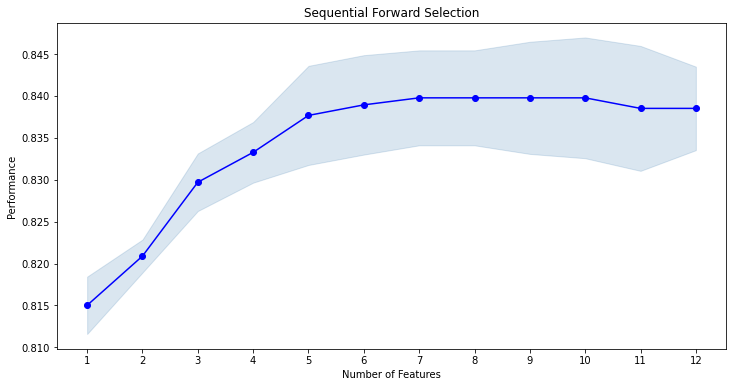

In [ ]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

plot_sfs(sfs.get_metric_dict())
plt.title('Sequential Forward Selection')

plt.show()

Lastly, let's check the AUC of the test set to see how this selection of features did on unseen data.



In [ ]:
X_train_sfs = sfs.transform(X_train)
X_test_sfs = sfs.transform(X_test)

clf.fit(X_train_sfs, np.ravel(y_train.values))
y_pred = clf.predict(X_test_sfs)

In [ ]:
roc_auc_score(y_test, y_pred)

0.6550612508059317

### Recursive feature elimination (backward selection)

Another extremely useful variable selection method is backward selection. We can actually implement it very easily using the `RFECV` function from `sklearn`. You can view the documentation for this function [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV). Let's see if it selects similar variables as our last wrapper model and the filter model.

In [ ]:
from sklearn.feature_selection import RFECV
clf = LogisticRegression(random_state=888, max_iter=10000, tol=0.001)

rfecv = RFECV(estimator=clf, step=1, cv=2, scoring='accuracy')
X_train_new = rfecv.fit(X_train,  np.ravel(y_train.values))

print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 14


In [ ]:
X_train.columns[rfecv.support_]

Index(['LOAN', 'MORTDUE', 'VALUE', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO',
       'DEBTINC', 'REASON_HomeImp', 'REASON_IsMissing', 'JOB_Office',
       'JOB_Sales', 'JOB_Self'],
      dtype='object')

In this regression, different variables were dropped and again they don't correspond to the candidates we found through our filter process. Again, this may be caused by some variable interaction, which we cannot observe by using filter methods. It is up to your discretion to experiment with combinations and determine the best course of action to solve your problem.

We can plot the percent correctly classified vs. the number of selected features to see the algorithm's findings.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


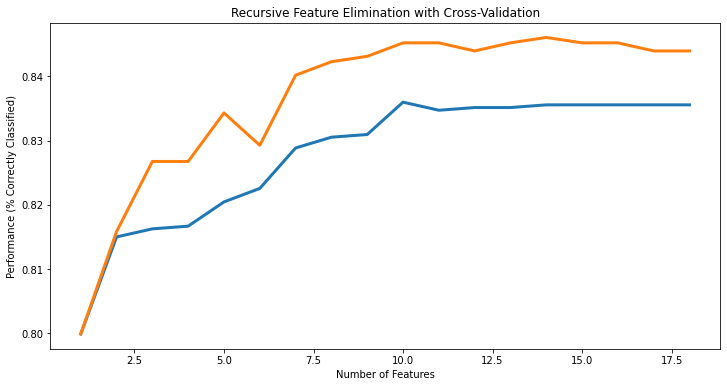

In [ ]:
plt.title('Recursive Feature Elimination with Cross-Validation')
plt.xlabel('Number of Features')
plt.ylabel('Performance (% Correctly Classified)')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, linewidth=3)

plt.show()

Lastly, let's check the mean error on the test set to see how this selection of features did on unseen data.

In [ ]:
y_pred = rfecv.predict(X_test)

roc_auc_score(y_test, y_pred)

0.6533942347295302